In [21]:
import os, time
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
dataset = datasets.ImageFolder("dataset/kaggle_cat_v1")

train_size = int(0.8 * len(dataset)) # 80%
val_size = len(dataset) - train_size # 20%

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

In [11]:
dataloaders = {
    name: torch.utils.data.DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        num_workers=4,
    ) for name, dataset in zip(["train", "val"], [train_dataset, val_dataset])
}

class_names = train_dataset.dataset.classes
dataset_sizes = {name: len(dataset) for name, dataset in zip(["train", "val"], [train_dataset, val_dataset])}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names, dataset_sizes, device

(['bengal', 'domestic_shorthair', 'maine_coon', 'ragdoll', 'siamese'],
 {'train': 761, 'val': 191},
 device(type='cpu'))

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss, running_corrects

In [10]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs
        labels = labels
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    return running_loss, running_corrects

In [8]:
def train_model(model, criterion, optimzer, scheduler, num_epochs=3):
    since = time.time()
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        history = []
        
        for epoch in range(num_epochs):
            train_loss, train_corrects = train_epoch(model, dataloaders["train"], criterion, optimzer, device)
            scheduler.step()
            val_loss, val_corrects = validate_epoch(model, dataloaders["val"], criterion, device)
            
            train_loss /= dataset_sizes["train"]
            train_acc = train_corrects.double() / dataset_sizes["train"]
            val_loss /= dataset_sizes["val"]
            val_acc = val_corrects.double() / dataset_sizes["val"]
            
            history.append([train_acc, val_acc, train_loss, val_loss])
            print(f"Epoch {epoch}/{num_epochs - 1}: "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)
                
        
            time_elapsed = time.time() - since
            print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
            print(f"Best val Acc: {best_acc:.4f}")
            
            model.load_state_dict(torch.load(best_model_params_path))
            
        return model, history

In [12]:
model_orig = torchvision.models.convnext_base(weights="IMAGENET1K_V1")
model_orig.classifier[2] = torch.nn.Linear(
    in_features=model_orig.classifier[2].in_features,
    out_features=len(class_names)
)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /Users/hwang-giseong/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [01:55<00:00, 3.07MB/s] 


In [14]:
model_ft = models.convnext_base(weights='IMAGENET1K_V1')
model_ft.classifier[2] = torch.nn.Linear(
    in_features=model_ft.classifier[2].in_features,
    out_features=len(class_names)
)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [15]:
model_ft, model_ft_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0: Train Loss: 0.9840, Acc: 0.6478, Val Loss: 0.6304, Acc: 0.7644

Training complete in 20m 29s
Best val Acc: 0.7644


In [16]:
model_conv = torchvision.models.convnext_base(weights="IMAGENET1K_V1")
for param in model_conv.parameters(): 
    param.requires_grad = False
    model_conv.classifier[2] = torch.nn.Linear(
        in_features=model_conv.classifier[2].in_features,
        out_features=len(class_names)
    )

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6, gamma=0.1)

In [17]:
model_conv, model_conv_history = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=1)

Epoch 0/0: Train Loss: 1.4898, Acc: 0.4336, Val Loss: 1.3828, Acc: 0.6283

Training complete in 7m 4s
Best val Acc: 0.6283


In [18]:
model_ft_history = pd.DataFrame(model_ft_history, columns=["Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"])
model_conv_history = pd.DataFrame(model_ft_history, columns=["Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"])

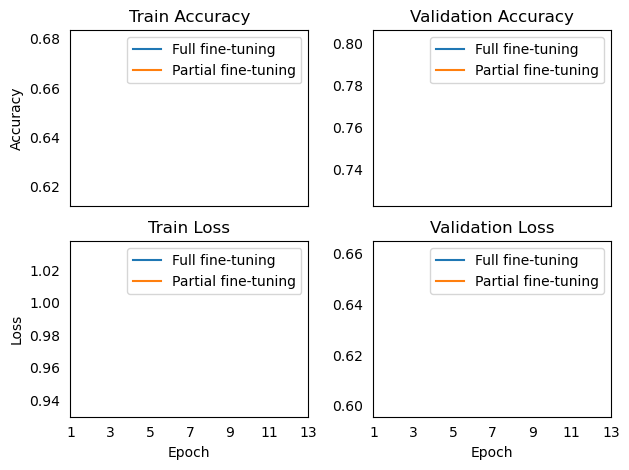

In [19]:
num_of_subplots = len(model_ft_history.columns)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

for i, title, ax in zip(range(num_of_subplots), model_ft_history.columns, [i for x in axs for i in x]):
    ax.plot(model_ft_history.iloc[:, i], label="Full fine-tuning")
    ax.plot(model_conv_history.iloc[:, i], label="Partial fine-tuning")
    ax.set_xticks(range(13))
    ax.set_xticklabels(("1", "", "3", "", "5", "", "7", "", "9", "", "11", "", "13"))
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    if i > 1: ax.set_xlabel("Epoch")
    if i == 0: ax.set_ylabel("Accuracy")
    if i == 2: ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()
    
plt.tight_layout()
plt.show()

In [20]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()
    
    img = Image.open(img_path)
    img = data_transforms["val"](img)
    img = img.unsqueeze(0)
    
    with torch.no_grad():
        outputs = model(img)
        _, preds =  torch.max(outputs, 1)
        
        model.train(mode=was_training)
        return outputs

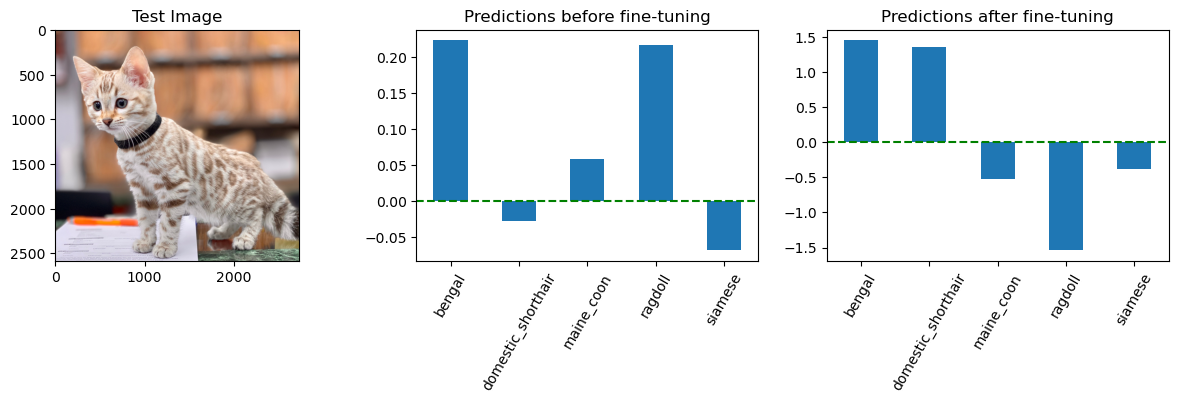

In [23]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

img = cv2.imread("dataset/kaggle_cat_v1/bengal/image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.imshow(img)
ax1.set_title("Test Image")

original_preds = visualize_model_predictions(model_orig, "dataset/kaggle_cat_v1/bengal/image.jpg")
ax2 = pd.Series(original_preds.data.cpu().numpy().tolist()[0]).plot(kind="bar", ax=ax2)
ax2.set_xticklabels(class_names, rotation=60)
ax2.axhline(y=0, color="green", linestyle="--")
ax2.set_title("Predictions before fine-tuning")

finetuned_preds = visualize_model_predictions(model_ft, "dataset/kaggle_cat_v1/bengal/image.jpg")
pd.Series(finetuned_preds.data.cpu().numpy().tolist()[0]).plot(kind="bar", ax=ax3)
ax3.set_xticklabels(class_names, rotation=60)
ax3.axhline(y=0, color='green', linestyle='--')
ax3.set_title("Predictions after fine-tuning")

plt.show()